In [1]:
import os
import numpy as np
from scipy import io
from pathlib import Path
from modules import preproc, rhino, source_recon, parcellation, hmm, utils
from osl_dynamics import inference, analysis
from osl_dynamics.utils import plotting
from osl_dynamics.data import Data
import mne
%matplotlib inline

2025-12-01 23:06:49.261506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764601609.302213 1051375 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764601609.316451 1051375 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764601609.353618 1051375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764601609.353663 1051375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764601609.353667 1051375 computation_placer.cc:177] computation placer alr

In [2]:
subject_id = "01_rest_eyecolsed"

In [3]:
raw = mne.io.read_raw_fif("eeg_data/01_rest_eyecolsed_raw.fif", preload=True)

Opening raw data file eeg_data/01_rest_eyecolsed_raw.fif...
    Range : 2000 ... 355480 =      2.000 ...   355.480 secs
Ready.
Reading 0 ... 353480  =      0.000 ...   353.480 secs...


In [4]:
raw = raw.filter(l_freq=1, h_freq=100, method="iir", iir_params={"order": 5, "ftype": "butter"})
raw = raw.resample(sfreq=250)
raw = preproc.detect_bad_segments(raw, picks="eeg", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="eeg", mode="diff", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="eeg", metric="kurtosis", significance_level=0.1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB


Bad segment detection
---------------------
Modality: eeg
Mode: None
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 0 bad segments: 0.0/353.5 seconds rejected (0.0%)

Bad segment detection
---------------------
Modality: eeg
Mode: diff
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 0 bad segments: 0.0/353.5 seconds rejected (0.0%)

Bad segment detection
---------------------
Modality: eeg
Mode: None
Metric: kurtosis
Significance level: 0.1
Maximum fraction: 0.1
Found 2 bad segments: 0.5/353.5 seconds rejected (0.1%)



ICA 自动伪影去除 (Method: iclabel)
----------------------------
正在过滤数据副本 (1-100Hz) 以进行 ICA 拟合...
应用平均参考 (ICLabel 要求)...
正在拟合 ICA (method='infomax', n_components=30, picks=eeg)...
Fitting ICA to data using 62 channels (please be patient, this may take a while)
Omitting 124 of 88370 (0.14%) samples, retaining 88246 (99.86%) samples.
Selecting by number: 30 components
Computing Extended Infomax ICA
Fitting ICA took 33.3s.
正在使用 iclabel 标记成分...
正在筛选伪影成分 (阈值 > 0.60)...
  ICA005: eye blink (置信度: 0.99) -> [标记去除]
  ICA013: eye blink (置信度: 0.98) -> [标记去除]
  ICA016: eye blink (置信度: 0.80) -> [标记去除]
  ICA018: muscle artifact (置信度: 0.46) -> [保留] (置信度低于阈值)
  ICA020: muscle artifact (置信度: 0.82) -> [标记去除]
  ICA021: muscle artifact (置信度: 0.35) -> [保留] (置信度低于阈值)
  ICA022: eye blink (置信度: 0.42) -> [保留] (置信度低于阈值)
  ICA023: muscle artifact (置信度: 0.46) -> [保留] (置信度低于阈值)
  ICA028: channel noise (置信度: 0.59) -> [保留] (置信度低于阈值)
总计发现 4 个待去除的伪影成分。正在绘图...


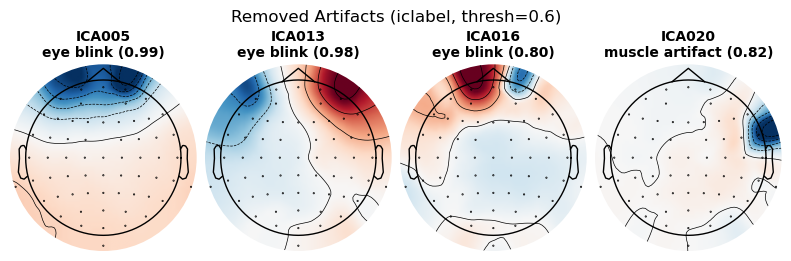

正在将 ICA 清洗应用到原始数据...
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 62 PCA components


In [5]:
raw = preproc.ica_ICLabel(raw, picks="eeg",n_components=30,threshold=0.6)

In [6]:
raw = raw.set_eeg_reference(projection=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [7]:
preproc_file = Path(f"eeg_data/preprocessed/{subject_id}_preproc-raw.fif")
preproc_file.parent.mkdir(parents=True, exist_ok=True)
raw.save(preproc_file, overwrite=True)

Overwriting existing file.
Writing /root/Canonical-HMM-Networks/eeg_data/preprocessed/01_rest_eyecolsed_preproc-raw.fif
Overwriting existing file.
Closing /root/Canonical-HMM-Networks/eeg_data/preprocessed/01_rest_eyecolsed_preproc-raw.fif
[done]


[PosixPath('/root/Canonical-HMM-Networks/eeg_data/preprocessed/01_rest_eyecolsed_preproc-raw.fif')]

In [8]:
from re import sub


fns = utils.OSLFilenames(
    outdir="eeg_data/osl",
    id=subject_id,
    preproc_file=f"eeg_data/preprocessed/{subject_id}_preproc-raw.fif",
    surfaces_dir="mni152_surfaces",  # replace with the 'outdir' used in rhino.extract_surfaces if you have your own structural
)
print(fns)

OSLFilenames for 01_rest_eyecolsed:
  Output directory:  eeg_data/osl
  Preprocessed file: eeg_data/preprocessed/01_rest_eyecolsed_preproc-raw.fif
  Surfaces directory: mni152_surfaces
  BEM directory:     eeg_data/osl/01_rest_eyecolsed/bem
  Coreg directory:   eeg_data/osl/01_rest_eyecolsed/coreg
    └─ Forward model: eeg_data/osl/01_rest_eyecolsed/coreg/model-fwd.fif
  Source directory:  eeg_data/osl/01_rest_eyecolsed/src
    └─ lcmv filters:  eeg_data/osl/01_rest_eyecolsed/src/filters-lcmv.h5


In [9]:
rhino.extract_polhemus_from_fif(fns, include_eeg_as_headshape=True)
rhino.coregister(
    fns,
    allow_smri_scaling=True,  # set to False if using a real structural
)


Extracting polhemus from fif info
---------------------------------
    Read a total of 1 projection items:
        Average EEG reference (1 x 62)  idle
Saved: eeg_data/osl/01_rest_eyecolsed/coreg/polhemus_nasion.txt
Saved: eeg_data/osl/01_rest_eyecolsed/coreg/polhemus_rpa.txt
Saved: eeg_data/osl/01_rest_eyecolsed/coreg/polhemus_lpa.txt
Saved: eeg_data/osl/01_rest_eyecolsed/coreg/polhemus_headshape.txt

Running coregistration
----------------------
    Read a total of 1 projection items:
        Average EEG reference (1 x 62)  idle
Creating RawArray with float64 data, n_channels=62, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Overwriting existing file.
Writing /root/Canonical-HMM-Networks/eeg_data/osl/01_rest_eyecolsed/coreg/info-raw.fif
Overwriting existing file.
Closing /root/Canonical-HMM-Networks/eeg_data/osl/01_rest_eyecolsed/coreg/info-raw.fif
[done]
Loading: eeg_data/osl/01_rest_eyecolsed/coreg/polhemus_headshape.txt
Loading: eeg_data/osl/01_rest_eyecol

In [10]:
rhino.forward_model(fns, model="Triple Layer", gridstep=8, meg=False, eeg=True)


Calculating forward model
-------------------------
Using bet_inskull_surf_file for single shell surface
Surface CM = (   0.5  -18.1    5.4) mm
Surface fits inside a sphere with radius   84.9 mm
Surface extent:
    x =  -63.5 ...   65.1 mm
    y =  -95.9 ...   65.9 mm
    z =  -64.4 ...   76.8 mm
Grid extent:
    x =  -64.0 ...   72.0 mm
    y =  -96.0 ...   72.0 mm
    z =  -72.0 ...   80.0 mm
7920 sources before omitting any.
4820 sources after omitting infeasible sources not within 0.0 - 84.9 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    4.0 mm away (will take a few...)
Checking surface interior status for 4820 points...
    Found  623/4820 points inside  an interior sphere of radius   42.3 mm
    Found    0/4820 points outside an exterior sphere of radius   84.9 mm
    Found 1936/4197 points outside using surface Qhull
    Found  163/2261 points outside using solid angles
    Total 2721/4820 points inside the surface
Int

In [11]:
source_recon.lcmv_beamformer(fns, raw, chantypes="eeg", rank={"eeg": 50})


Making LCMV beamformer
----------------------
Reading forward solution from /root/Canonical-HMM-Networks/eeg_data/osl/01_rest_eyecolsed/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (2313 sources, 62 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Using up to 1767 segments
Number of samples used : 88150
[done]
Variance for chantype eeg is 4.779975679619686e-11
Computing rank from covariance with rank={'eeg': 50}
Computing rank from covariance with rank='info'
    EEG: rank 61 after 1 projector applied to 62 channels
Making LCMV beamformer with data cov rank {'eeg': 50}
Making LCMV beamformer with noise cov rank {'eeg': 61}
Computing inverse operator with 62 channels.
    62 out of 62 channels remain after picking
Selected 62 channels
Whitening the forward solution.
    Created 

In [12]:
voxel_data, voxel_coords = source_recon.apply_lcmv_beamformer(fns, raw)


Applying LCMV beamformer
------------------------
Omitting 124 of 88370 (0.14%) samples, retaining 88246 (99.86%) samples.
Reading forward solution from /root/Canonical-HMM-Networks/eeg_data/osl/01_rest_eyecolsed/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (2313 sources, 62 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
spatial_resolution = 8 mm
mask_file: eeg_data/osl/01_rest_eyecolsed/src/MNI152_T1_8mm_brain.nii.gz
Finding nearest neighbour in resampled MNI space


In [2]:
parcellation_file = "fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz"

parcel_data = parcellation.parcellate(
    fns,
    voxel_data,
    voxel_coords,
    method="spatial_basis",
    orthogonalisation="symmetric",
    parcellation_file=parcellation_file,
)

parc_fif = f"eeg_data/osl/{subject_id}/lcmv-parc-raw.fif"
parcellation.save_as_fif(
    parcel_data,
    raw,
    extra_chans="stim",
    filename=parc_fif,
)

NameError: name 'fns' is not defined

In [4]:
parcellation_file = "fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz"
parc_fif = "eeg_data/osl/01_rest_eyecolsed/lcmv-parc-raw.fif"

Opening raw data file eeg_data/osl/01_rest_eyecolsed/lcmv-parc-raw.fif...
Isotrak not found
    Range : 500 ... 88869 =      2.000 ...   355.476 secs
Ready.
Omitting 124 of 88370 (0.14%) samples, retaining 88246 (99.86%) samples.


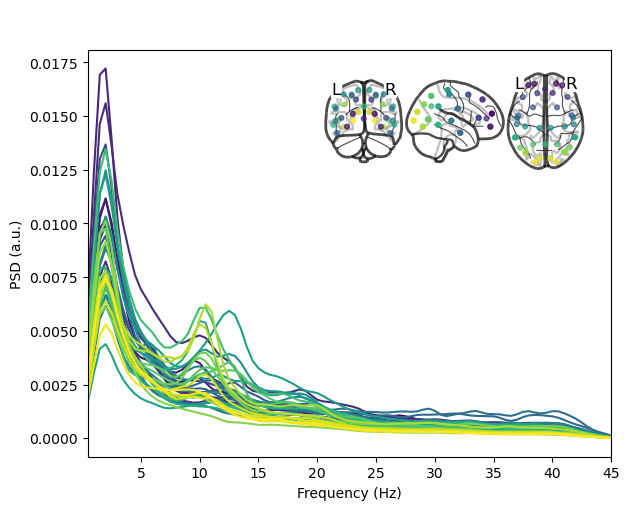

In [5]:
parcellation.plot_psds(parc_fif, parcellation_file=parcellation_file)